# Electricity Load Forecasting with Machine Learning

@LBNL by NH :thumbsup:

## Imports

In [54]:
import os, sys
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import darts
from darts.utils.statistics import check_seasonality, plot_acf, stationarity_tests
from darts.dataprocessing.transformers.missing_values_filler import MissingValuesFiller
from darts.dataprocessing.transformers.boxcox import BoxCox
from darts.dataprocessing.transformers.diff import Diff
from darts.utils.statistics import plot_hist
from darts.utils.losses import MAELoss
from darts.models import LightGBMModel, XGBModel, LinearRegressionModel, TFTModel, NHiTSModel, NLinearModel, DLinearModel, TransformerModel
from darts.metrics import smape, mape, mase, mse, rmse, r2_score, mae
from darts.dataprocessing.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler   
from darts.dataprocessing.transformers.scaler import Scaler

import wandb 
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping, Callback
from pytorch_lightning.callbacks import ModelCheckpoint
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

from utils import *


import warnings
warnings.filterwarnings('ignore')


In [3]:
# Set working directory
os.chdir(r"..") # should be the git repo root directory
print("Current working directory: " + os.getcwd())
assert os.getcwd()[-8:] == "WattCast"

#PATHS
RESULTS_PATH = r"results"
DATA_PATH = r"data"
MODEL_PATH = r"models"

Current working directory: c:\Users\nik\Desktop\Berkeley_Projects\WattCast


## 0) Loading the data

In [4]:
# Electricity Load data (target)
df_list = []
df_load = load_data(DATA_PATH, "ger", data_type='power')
df_load = drop_duplicate_index(df_load)
df_load = df_load.resample('H').mean()
freq = infer_frequency(df_load)
print(f'The frequency of the data is {freq}.')

The frequency of the data is H.


<Axes: xlabel='index'>

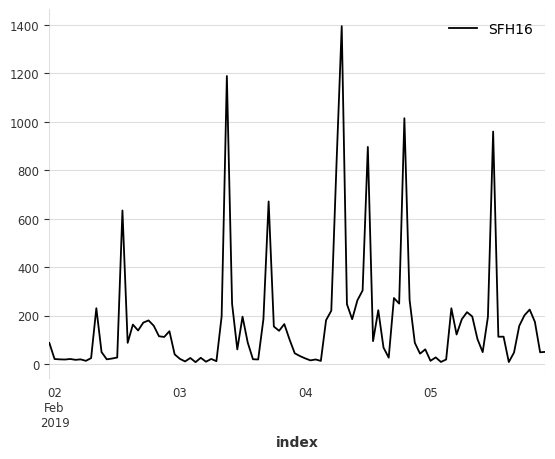

In [22]:
# PLotting an example of the data
df_load.iloc[192:192+96, [4]].plot()

In [6]:
ts_list = []
for col in df_load:
    ts = darts.TimeSeries.from_dataframe(df_load[[col]], freq=freq).astype(np.float32) # to float32 for GPU
    ts.name = col
    ts_list.append(ts)

locations = df_load.columns

## 1) Exploratory Data Analysis (EDA) & Data Cleaning

In [5]:
df_load.describe()

,SFH10,SFH11,SFH12,SFH14,SFH16,SFH17,SFH18,SFH19,SFH20,SFH21,...,SFH38,SFH39,SFH4,SFH40,SFH5,SFH6,SFH7,SFH8,SFH9,SFH42
count,28084.000000,28084.000000,28084.000000,28084.000000,28084.000000,28084.000000,28084.000000,28084.000000,28084.000000,28084.000000,...,28084.000000,28084.000000,28084.000000,28084.000000,28084.000000,28084.000000,28084.000000,28084.000000,28084.000000,28084.000000
mean,343.429549,216.404347,259.877643,147.936103,168.332815,212.180915,242.249076,217.886683,234.675652,205.997034,...,250.201631,134.066230,182.470333,250.576605,193.839569,41.343232,266.718018,308.230267,415.147453,349.104683
std,421.956510,359.104436,525.721116,264.948307,359.939527,385.042459,473.813138,363.821529,384.486490,287.790604,...,316.588897,251.928503,275.314582,440.283838,347.431752,179.980535,392.748977,481.880230,691.920531,443.362398
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,116.323974,42.624194,57.678389,5.601500,25.820250,0.000000,40.156306,76.424917,60.449778,73.880028,...,96.991055,38.147667,70.133666,0.000000,36.535612,0.000000,73.893667,61.321750,100.431195,147.600000
50%,210.692780,91.874166,96.337833,48.215945,46.506667,85.842387,80.624444,124.023167,109.268889,123.320612,...,160.014222,86.477056,114.597000,97.316945,116.592112,0.000000,145.479834,109.068944,177.842944,222.066667
75%,373.278807,198.361667,176.163944,161.740722,128.972250,222.187694,204.267805,208.876859,219.058305,214.510083,...,289.537694,140.749167,196.524278,251.012999,191.998943,0.000000,261.602472,289.753444,322.191916,336.333333
max,4857.874561,4078.053559,6388.520797,3794.171701,3674.416443,4973.423768,6526.576999,5334.529797,4866.524142,4231.036237,...,4695.227320,4026.966422,4100.782780,5585.017747,4635.717562,4777.340091,4019.097777,5562.279884,6693.490996,5064.066667


In [ ]:
df_load.isna().sum() / len(df_load) # percentage of missing values for each location -> seems clean

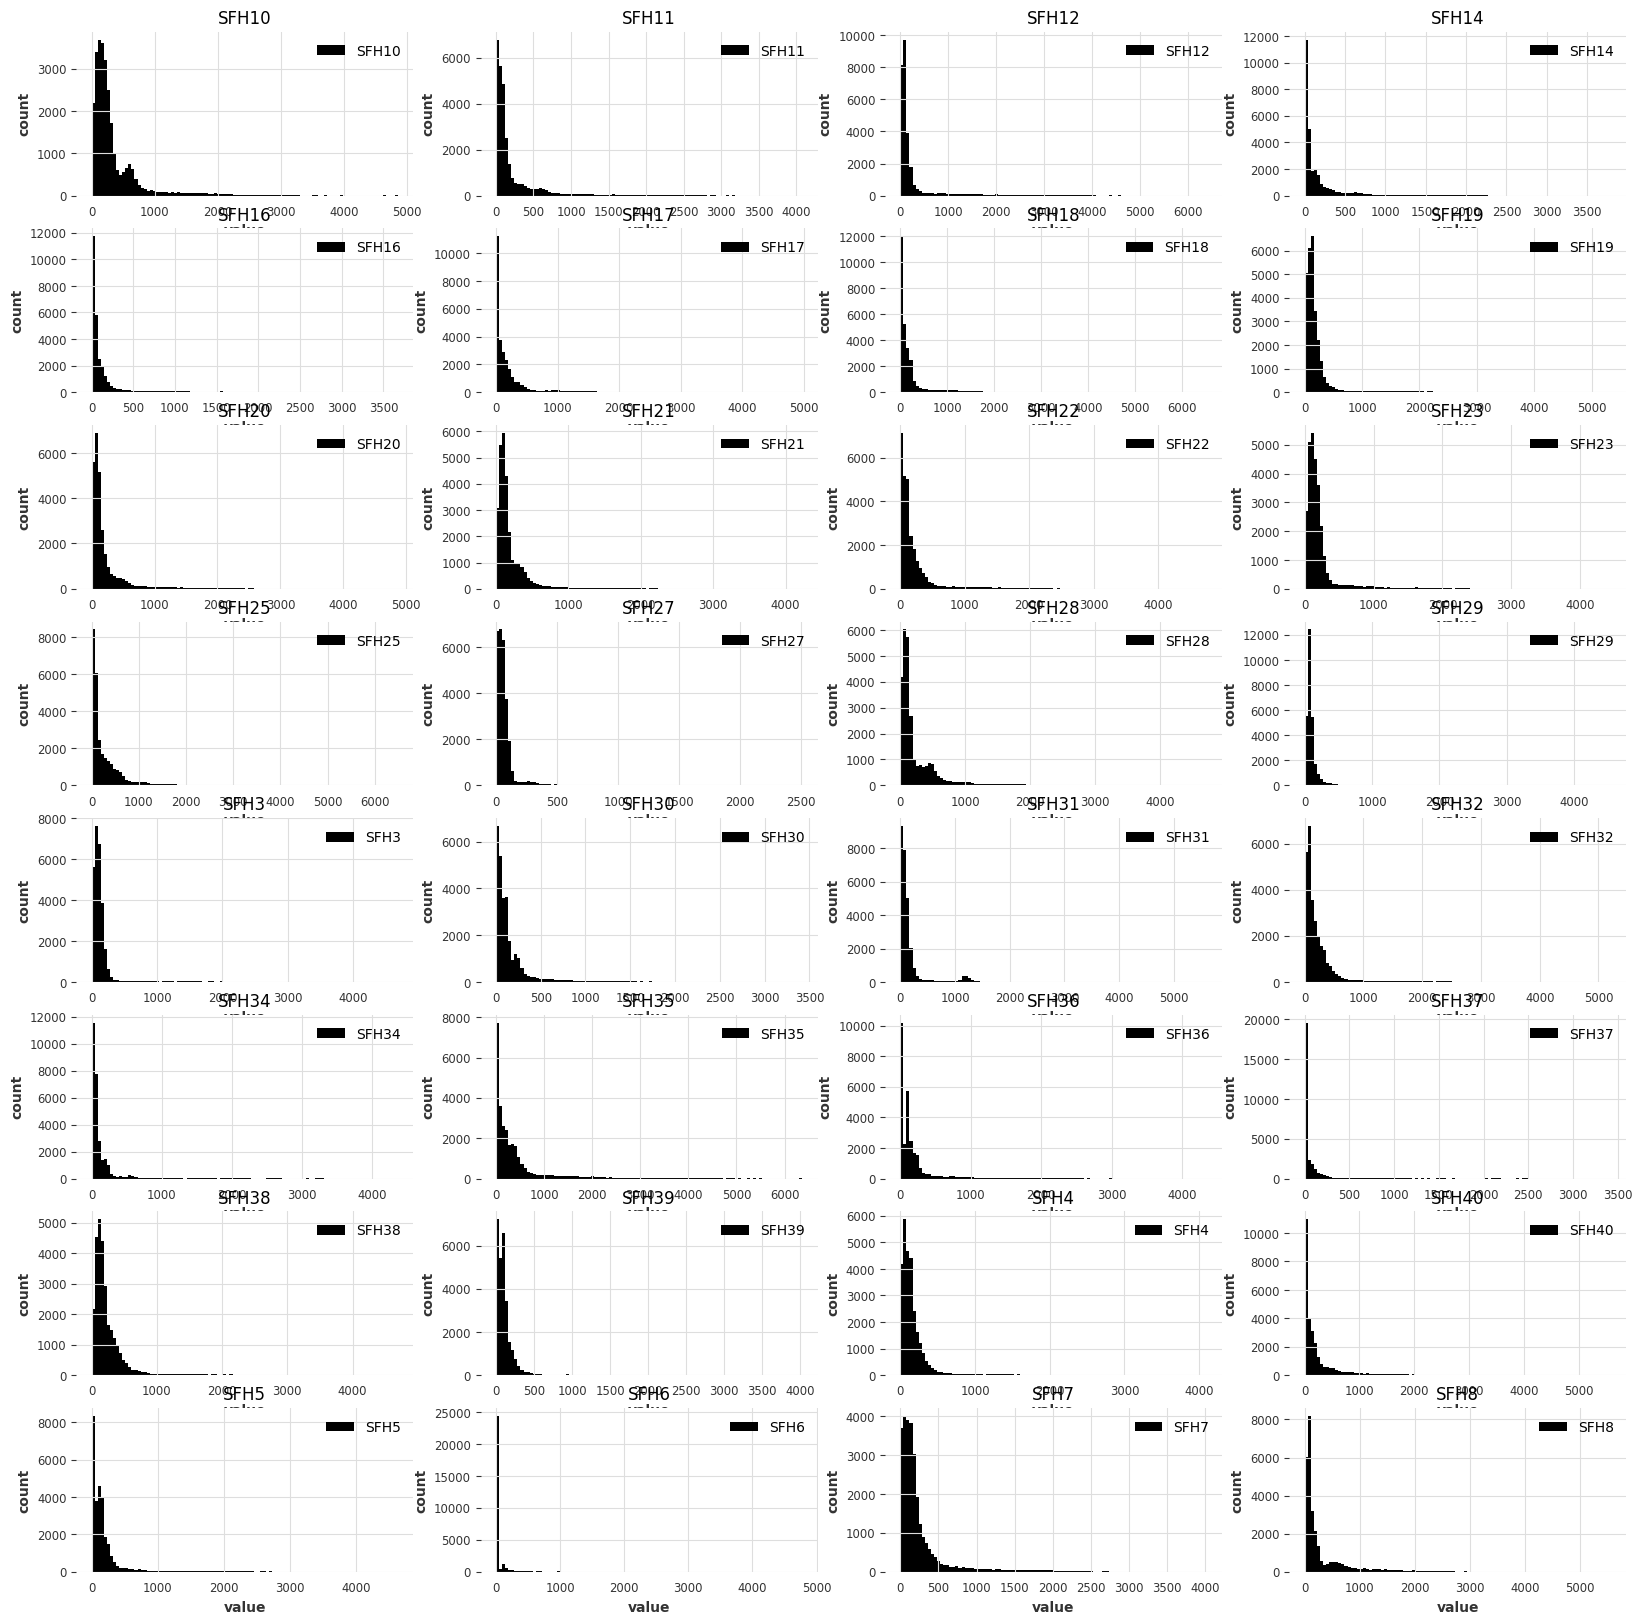

In [26]:
#Checking the distribution of the data, we see that the data is not normally distributed, but has a long/fat tail. 
#This motivates the us of a box-cox transformation.

n_rows = len(ts_list)//4
n_cols = 4

fig, ax = plt.subplots(nrows=n_rows, ncols= n_cols, figsize=(20, 20))
for i, ts in enumerate(ts_list):
    plot_hist(ts, ax=ax[i//n_cols, i%n_cols], bins=100)
    ax[i//n_cols, i%n_cols].set_title(ts.name)

## 2) Modeling

### Train, validation, test split

In [7]:
IDX = 0 # index of the location we want to train the model on
# print which location was selected by idx
print(f'Location is {locations[IDX]}')

# we will make the split 70-15-15

ts_length = len(ts_list[IDX])
train_end = int(0.7 * ts_length)
val_end = int(0.85 * ts_length)

train_end = ts_list[IDX].get_timestamp_at_point(train_end)
val_end = ts_list[IDX].get_timestamp_at_point(val_end)

ts_train_list, ts_val_list, ts_test_list = train_val_test_split(ts_list, train_end, val_end)

# pretty print the first and last index of "la"
print(f'First index: {ts_list[IDX].start_time()}. Last index: {ts_list[IDX].end_time()}.')
print(f'Train end: {ts_train_list[IDX].end_time()}. Validation end: {ts_val_list[IDX].end_time()}. Test end: {ts_test_list[IDX].end_time()}.')
print(f'Train length: {len(ts_train_list[IDX])}. Validation length: {len(ts_val_list[IDX])}. Test length: {len(ts_test_list[IDX])}.')




Location is SFH10
First index: 2019-01-24 23:00:00. Last index: 2019-11-13 12:00:00.
Train end: 2019-08-17 18:00:00. Validation end: 2019-09-30 15:00:00. Test end: 2019-11-13 12:00:00.
Train length: 4916. Validation length: 1054. Test length: 1054.


### Data Pipeline

This will be an invertible data pipline that transforms the data from the original form to the form that the model expects, and then back to the original form.
The pipeline includes the following steps, in the fashion we saw before:
1. Missing values imputation
2. BoxCox transformation
3. Differencing
4. Scaling



In [8]:
# Target pipeline
pipeline = Pipeline(
                    [
                    MissingValuesFiller(),
                    #BoxCox(lmbda=0.3), 
                    Scaler(MinMaxScaler(feature_range=(-1, 1))),
                    ]
                     )


ts_train_list_piped = pipeline.fit_transform(ts_train_list)
ts_val_list_piped = pipeline.transform(ts_val_list)
ts_test_list_piped = pipeline.transform(ts_test_list)



### Model Creation

In [55]:
#trg, covs = make_index_same(ts_test_list_piped[IDX], ts_test_weather_list_piped[IDX])
trg = ts_train_list_piped[IDX][:500]
trg_inversed = pipeline.inverse_transform(ts_train_list_piped[IDX], partial=True)[:500] # inverse transform the target, we need the original values for the evaluation

N_LAGS = 24 # timesteps lookback
N_AHEAD = 24 # timesteps horizon
LIKLIHOOD = None

encoders = {
            "cyclic": {"future": ["hour"]}, 
            "position": {"future": ["relative",]},
            "datetime_attribute": {"future": ["dayofweek", "week"]}
            }


encoders_trafo = {
            "cyclic": {"past": ["hour"]}, 
            "position": {"past": ["relative"]},
            "datetime_attribute": {"past": ["dayofweek", "week"]}
            }

### Scikit & Co

In [10]:
model_lgb = LightGBMModel(lags=N_LAGS,
                      lags_future_covariates=[0],
                      add_encoders=encoders, 
                      output_chunk_length=N_AHEAD, 
                      likelihood=LIKLIHOOD)

model_xgb = XGBModel(lags=N_LAGS,
                      lags_future_covariates=[0],
                      add_encoders=encoders, 
                      output_chunk_length=N_AHEAD, 
                      likelihood=LIKLIHOOD)


model_lr = LinearRegressionModel(lags=N_LAGS,
                      lags_future_covariates=[0],
                      add_encoders=encoders, 
                      output_chunk_length=N_AHEAD, 
                      likelihood=LIKLIHOOD)


list_sklearn_models= [
                        model_lgb,
                        model_xgb, 
                        #model_lr
                        ]

numer_of_sklearn_models = len(list_sklearn_models)

### Deep Learning

In [60]:
# Using weights and biases for logging
run = wandb.init(project="load_forecasting_lbl", reinit=True)

wandb_logger = WandbLogger(reinit=True, log_model="all")

early_stopping = EarlyStopping(monitor="val_loss", patience=10)

lrmonitor = LRMonitor()

# set the device to gpu if available
device = "cuda" if torch.cuda.is_available() else "cpu"

# set the kwargs for the pytorch lightning trainer
pl_trainer_kwargs = {
                    "accelerator": device, 
                    "gpus": [0], 
                    "auto_lr_find":False, 
                    "logger": wandb_logger, 
                    "callbacks":[
                                    early_stopping,
                                    lrmonitor
                                    
                                ],
                    #"precision": 'mixed',
                    #"amp_level": "O1",
                    }

lr_schedule_kwargs = {"mode": "min", "factor": 0.5, "patience": 5, "verbose": True, "threshold": 0.0001, "threshold_mode": "rel", "cooldown": 0, "min_lr": 0.0001, "eps": 1e-08}


MODEL_CLASS = TransformerModel
nn_model = MODEL_CLASS(
                    model_name = run.id,
                    input_chunk_length=N_LAGS,
                    output_chunk_length=N_AHEAD,
                    #add_encoders=encoders_trafo,
                    num_encoder_layers=1,
                    dropout=0.1,
                    batch_size=1024,
                    #hidden_size=128,
                    pl_trainer_kwargs=pl_trainer_kwargs,
                    lr_scheduler_cls = ReduceLROnPlateau,
                    lr_scheduler_kwargs = lr_schedule_kwargs,
                    #loss_fn = MAELoss(),
                    save_checkpoints = True,
                    work_dir=MODEL_PATH, # This is necessary for proper imports of the model
                    )


epoch,▁▂▃▄▅▅▆▇█
trainer/global_step,▁▂▃▄▅▅▆▇█
val_loss,█▄▅▂▁▁▁▁▁
epoch,8
trainer/global_step,44
val_loss,0.13208


In [61]:
nn_model.fit(ts_train_list_piped[IDX],
            val_series = ts_val_list_piped[IDX], 
            verbose=True, 
            epochs = 50,
            num_loader_workers =2)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 128   
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 382 K 
6 | decoder             | Linear              | 1.6 K 
------------------------------------------------------------
384 K     Trainable params
0         Non-trainable params
384 K     Total params
1.537     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [62]:
# Download the model from wandb
run = wandb.run

#run_id = "4xvl3u76"
artifact_dir = run.use_artifact(f'wattcast/load_forecasting_lbl/model-{run.id}:best_k', type='model').download()
base_path = os.path.join(MODEL_PATH, run.id, "_model.pth.tar")
checkpoint_path = f"{artifact_dir}\model.ckpt"
model = load_from_model_artifact_checkpoint(MODEL_CLASS, base_path, checkpoint_path)



wandb:   1 of 1 files downloaded.  


### Training Slearn Models

In [12]:
# Train the models
models = train_models(list_sklearn_models, 
                        ts_train_list_piped[IDX], 
                        #ts_train_weather_list_piped[0]
                        )


### Appending the nn model

In [65]:
models = [] # comment out this line if you also trained sklearn models
models.append(model) # add the tft model to the list of models if it was trained
model_names = [model.__class__.__name__ for model in models]
print(model_names)

['TransformerModel']


In [66]:
# Generating Historical Forecasts for each model

ts_predictions_per_model = {}
historics_per_model = {}


for model in models:
    model_name = model.__class__.__name__
    historics = model.historical_forecasts(trg, 
                                        #future_covariates= covs,
                                        start=trg.get_index_at_point(N_LAGS),
                                        verbose=True,
                                        stride=N_AHEAD // 12, 
                                        forecast_horizon=N_AHEAD, 
                                        retrain=False, 
                                        last_points_only=False, # leave this as False unless you want the output to be one series, the rest will not work with this however
                                        #num_samples=30 # only enable when using quantile regression likelihood
                                        )
    
    historics_per_model[model_name] = historics # storing the forecasts in batches of the forecasting horizon, for plot 1
    ts_predictions = ts_list_concat(historics) # concatenating the batches into a single time series for plot 2
    ts_predictions_inverse = pipeline.inverse_transform(ts_predictions, partial=True) # inverse transform the predictions, we need the original values for the evaluation
    ts_predictions_per_model[model_name] = ts_predictions_inverse

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), us

## 3) Model Evaluation

### Plot I: Error Score across forecast horizon:

:+1: The objective of the plot below is to see how the error score evolves over the forecast horizon.
To do so, we align the predictions in a way that the first prediction of each forecast is aligned with the first ground truth value, the second prediction is aligned with the second ground truth value, and so on. Note that the number of forecasts depends on the argument: 'stride' in the "
We then compute the error score for each prediction and plot the results.
Lastly we need to divide by the average of the ground truth values to get the relative error score. This accounts for the fact that the ground truth values are not constantm

In [67]:

df_smapes_per_model = []
df_nrmse_per_model = []

for model_name, historics in historics_per_model.items():
    df_list = get_df_compares_list(historics, trg)
    means_per_timestep = pd.concat(df_list, axis=1).filter(like = "gt").mean(axis=1).values # mean of the ground truth values on a timestep basis
    diffs = get_df_diffs(df_list)
    df_smapes = abs(diffs).mean(axis =1) / means_per_timestep # mean of the relative errors on a timestep basis
    df_nrmse = np.square(diffs).mean(axis =1) / means_per_timestep # mean of the relative errors on a timestep basis

    df_smapes_per_model.append(df_smapes)
    df_nrmse_per_model.append(df_nrmse)

df_smapes_per_model = pd.concat(df_smapes_per_model, axis=1)
df_nrmse_per_model = pd.concat(df_nrmse_per_model, axis=1)



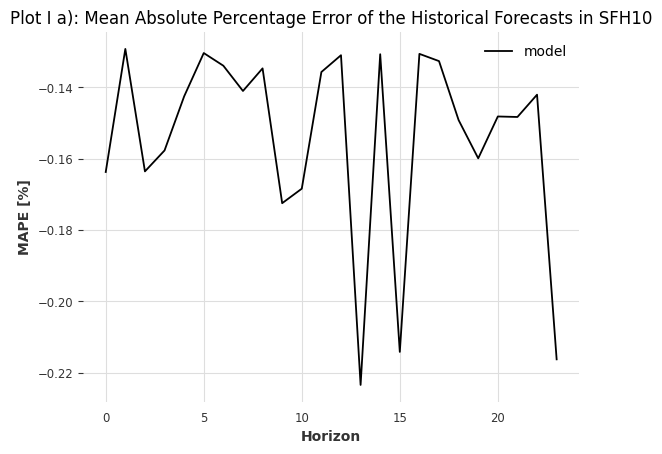

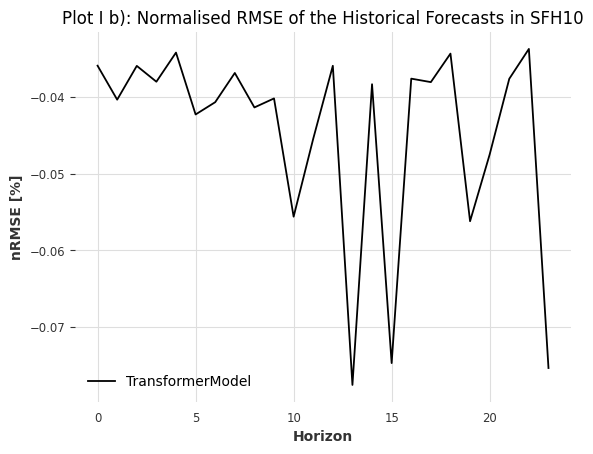

In [68]:
save = False

df_smapes_per_model.columns = ["model"]
df_smapes_per_model.plot()
plt.xlabel('Horizon')
plt.ylabel('MAPE [%]')
plt.legend()
plt.title(f"Plot I a): Mean Absolute Percentage Error of the Historical Forecasts in {locations[IDX]}")
if save:
    plt.savefig(f"{RESULTS_PATH}//figs_nh//households//smape.png")

df_nrmse_per_model.columns = model_names
df_nrmse_per_model.plot()
plt.xlabel('Horizon')
plt.ylabel('nRMSE [%]')
plt.legend()
plt.title(f"Plot I b): Normalised RMSE of the Historical Forecasts in {locations[IDX]}")
if save:
    plt.savefig(f"{RESULTS_PATH}//figs_nh//households//nrmse.png")

### Plot II: Side-by-side comparison of the predictions and the ground truth

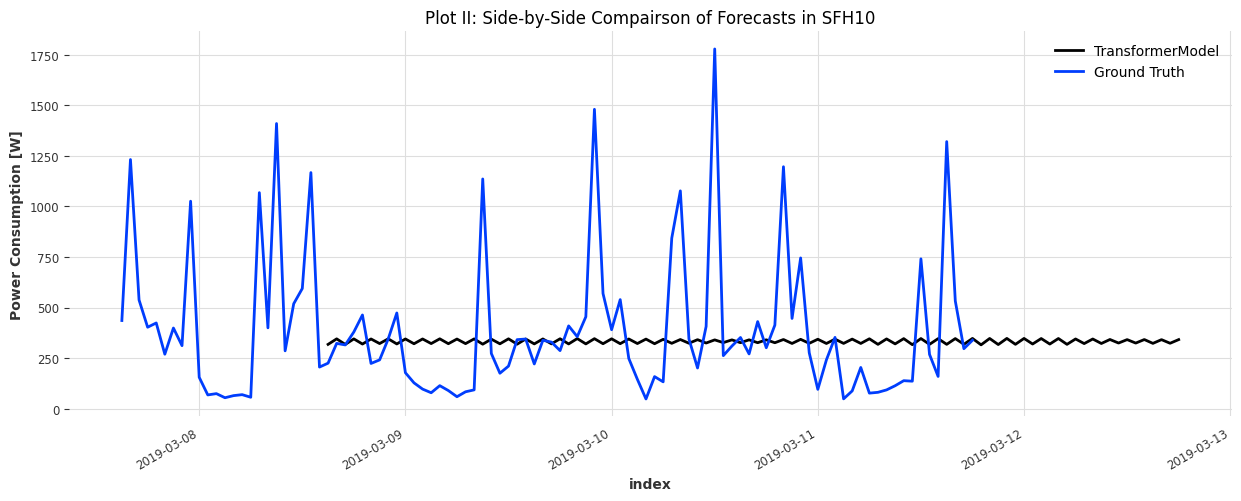

In [69]:
window_start =1000
window_end = 1100


for model_name, ts_predictions_inverse in ts_predictions_per_model.items():
    ts_predictions_inverse[window_start:window_end].plot(label = model_name)

trg_inversed[window_start:window_end].plot(label='Ground Truth')
plt.title(f"Plot II: Side-by-Side Compairson of Forecasts in {locations[IDX]}")
plt.legend()
plt.ylabel('Power Consumption [W]')
# adjust the figure size
plt.gcf().set_size_inches(15, 5)
if save:
    plt.savefig(f"{RESULTS_PATH}//figs_nh//households//comparisons.png")



### Plot III: Interactive Side-by-Side Comparison of the Forecasts and the Ground Truth

You can select the time you want to look at closer by drawing up a window with your mouse (click and move horizontally)

In [70]:

df_forecasts_all_models = []

for model_name, ts_predictions_inverse in ts_predictions_per_model.items():

    df_forecasts = ts_predictions_inverse.pd_dataframe()
    df_forecasts.columns = ['Forecast: {}'.format(model_name)]
    df_forecasts_all_models.append(df_forecasts)

df_forecasts_all_models = pd.concat(df_forecasts_all_models, axis=1)

df_gt = trg_inversed.pd_dataframe()
df_gt.columns = ['Ground truth']
df_compare = pd.concat([df_forecasts_all_models, df_gt], axis=1)
px.line(df_compare, title='Forecast vs. Ground Truth: {}'.format(locations[IDX]))

### Plot IV: Raw Error distribution

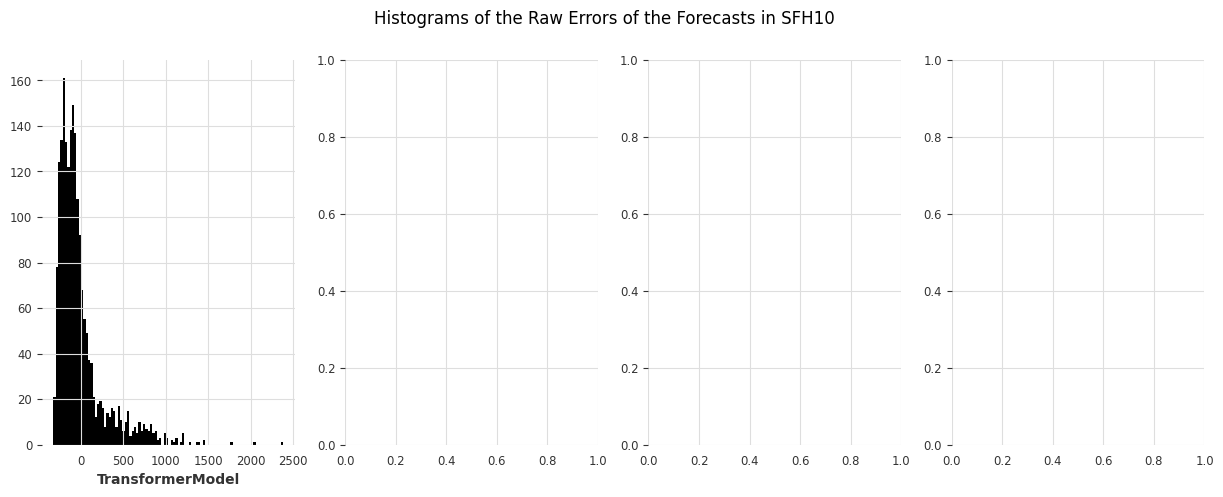

In [71]:
fig, ax = plt.subplots(ncols=4, figsize=(15, 5))

for i, (model_name, ts_predictions_inverse) in enumerate(ts_predictions_per_model.items()):
    
    ts_predictions_inverse, trg_inversed = make_index_same(ts_predictions_inverse, trg_inversed)
    errors = trg_inversed.values() - ts_predictions_inverse.values()
    ax[i].hist(errors, bins=100, label=model_name)
    #start a new plot
    ax[i].set_xlabel(model_name)

# set the title of the figure
fig.suptitle('Histograms of the Raw Errors of the Forecasts in {}'.format(locations[IDX]))
if save:
    fig.savefig(f"{RESULTS_PATH}//figs_nh///{locations[IDX]}//error_distribution.png")

### Table of Error Metrics